# Personalized User-level DP

In [1]:
import numpy as np

import os
path_project = os.path.dirname(os.path.abspath('.'))
import sys
sys.path.append(os.path.join(path_project, 'src'))
sys.path.append(os.path.join(path_project, 'exp/script'))

img_path = os.path.join(path_project, 'exp', 'img')
pickle_path = os.path.join(path_project, 'exp', 'pickle')
results_path = os.path.join(path_project, 'exp', 'results')

from personalized_utils import (
    make_q_c_curve, plot_q_c_curve, 
    make_epsilon_u, group_by_closest_below,
    static_optimization, show_static_optimization_result,
    prepare_grid_search,
    run_online_optimization, show_online_optimization_result,
    run_with_specified_idx, show_specified_idx_result,
    plot_acc_results,
)
from mylogger import logger_set_warning, logger_set_info

is_from_pickle = False


# qC curve
Given following parameters, the q C pair satisfying the privacy constraint has many candidates
- epsilon_u
- delta
- n_round
- sigma


In [4]:
# Figure of q_c_pair.png
epsilon_u = 3.0
n_round = 20
delta = 1e-5
sigma = 0.5
x, y = make_q_c_curve(epsilon_u=epsilon_u, delta=delta, sigma=sigma, num_points=30, n_round=n_round, min=-6)
plot_q_c_curve(
    x, y,
    title=r"$\epsilon_u={}$, $\delta={}$, $\sigma={}$,  $T={}$".format(
                epsilon_u, delta, sigma, n_round,
            )
)

KeyboardInterrupt: 

# PULDP-AVG

## Offline HPO

### HeartDisease

#### Test with all of HPs for showing group-independency (Figure in Appendix)

Basic setting 

(This setup is close to the real world, and each group has a different number of users and different privacy budgets, so the optimal HP is likely to be different.)

- (eps1, eps2, eps3) = (0.15, 3.0, 5.0)
- with ratio (eps1, eps2, eps3) = (0.6, 0.25, 0.15)

Result image saved to: /Users/fumiyuki/research/AcSilo/acsilo/exp/img/static_optimization_result-top20-group0-heart_disease-users-400.png


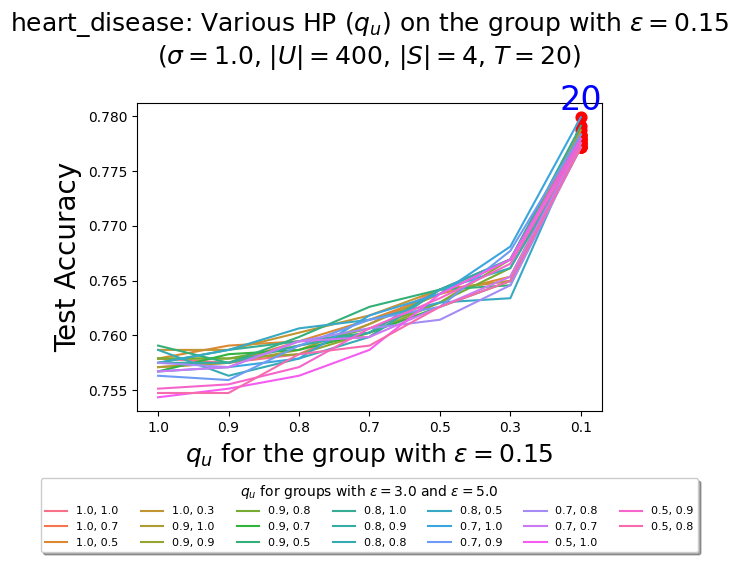

Result image saved to: /Users/fumiyuki/research/AcSilo/acsilo/exp/img/static_optimization_result-top20-group1-heart_disease-users-400.png


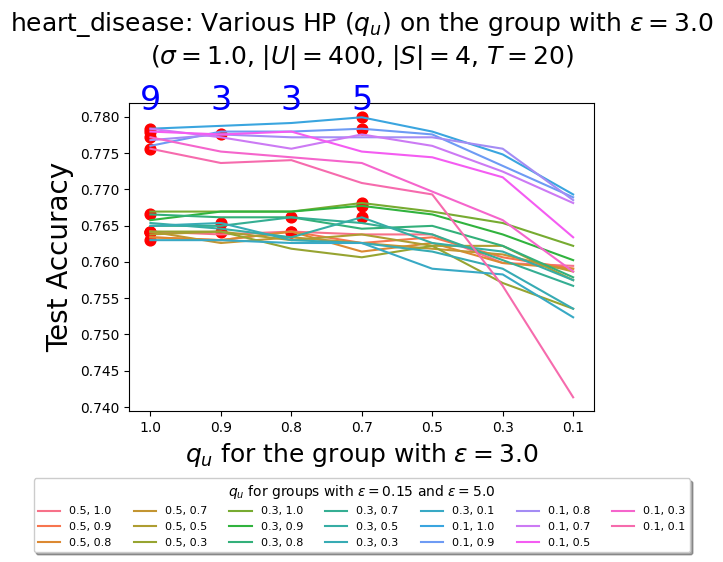

Result image saved to: /Users/fumiyuki/research/AcSilo/acsilo/exp/img/static_optimization_result-top20-group2-heart_disease-users-400.png


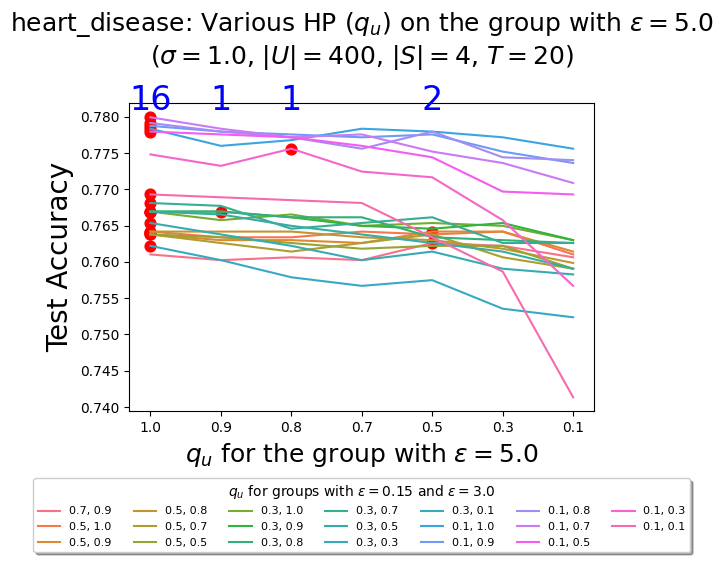

min_idx = {0.15: 6, 3.0: 0, 5.0: 0}, min_loss = 0.4785515457391739


In [ ]:
sigma = 1.0
n_users = 400
epsilon_list = [0.15, 3.0, 5.0]
group_thresholds = epsilon_list
ratio_list = [0.6, 0.25, 0.15]
delta = 1e-5
n_round = 20
dataset_name = 'heart_disease'
q_step_size = 0.7
times = 10
validation_ratio = 0.0
static_q_u_list = [1.0, 0.9, 0.8, 0.7, 0.5, 0.3, 0.1]

random_state = np.random.RandomState(0)
epsilon_u = make_epsilon_u(n_users=n_users, dist="hetero", epsilon_list=epsilon_list, ratio_list=ratio_list, random_state=random_state)
grouped = group_by_closest_below(epsilon_u_dct=epsilon_u, group_thresholds=group_thresholds)
epsilon_u = {}
for eps_u, user_ids in grouped.items():
    for user_id in user_ids:
        epsilon_u[user_id] = eps_u
opt_strategy = prepare_grid_search(epsilon_u, start_idx=0, end_idx=7)

logger_set_warning()
if not is_from_pickle:
    static_optimization(
        epsilon_u, sigma, delta, n_users, n_round, dataset_name, times, 
        q_step_size, opt_strategy=opt_strategy, global_learning_rate=10.0, 
        local_learning_rate=0.001, local_epochs=30, validation_ratio=validation_ratio, 
        user_dist="uniform-iid", silo_dist="uniform", 
        static_q_u_list=static_q_u_list
    )
min_idx, min_loss = show_static_optimization_result(
    epsilon_u, sigma, delta, n_users, n_round, dataset_name, 
    q_step_size, n_silos=4, opt_strategy=opt_strategy, validation_ratio=validation_ratio,
    train_loss=False, img_name=f"heart_disease-users-{n_users}", is_3d=True, 
    static_q_u_list=static_q_u_list, user_dist="uniform-iid", global_learning_rate=10.0, local_learning_rate=0.001, local_epochs=30
)
print(f"min_idx = {min_idx}, min_loss = {min_loss}")

#### Various n_users with a single eps group (Fig in Sec4)

Result image saved to: /Users/fumiyuki/research/AcSilo/acsilo/exp/img/static_optimization_result-1d-heart_disease-uniform-users-50.png


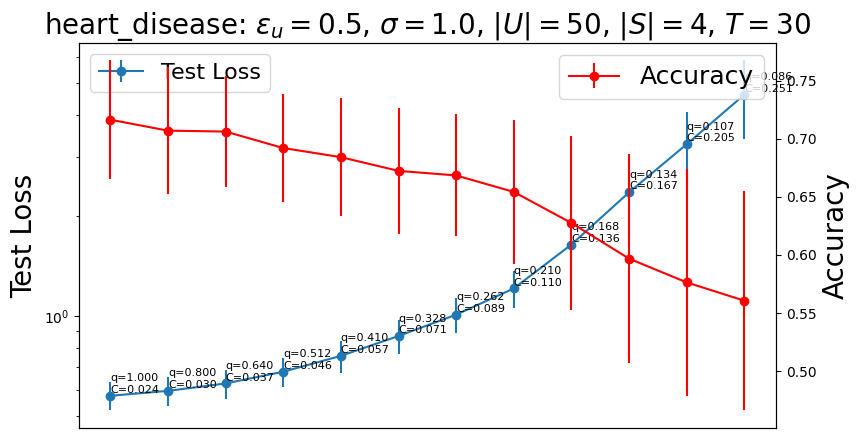

{0.5: 0} 0.5754557847976685
Result image saved to: /Users/fumiyuki/research/AcSilo/acsilo/exp/img/static_optimization_result-1d-heart_disease-uniform-users-100.png


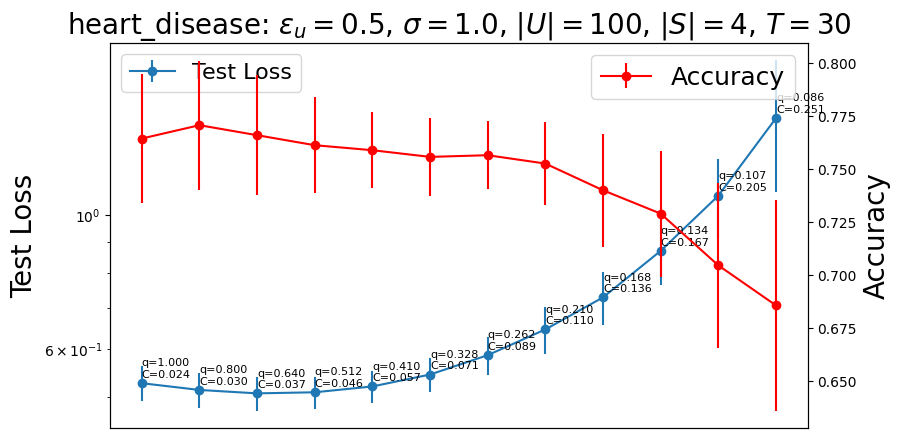

{0.5: 2} 0.5067352712154388
Result image saved to: /Users/fumiyuki/research/AcSilo/acsilo/exp/img/static_optimization_result-1d-heart_disease-uniform-users-200.png


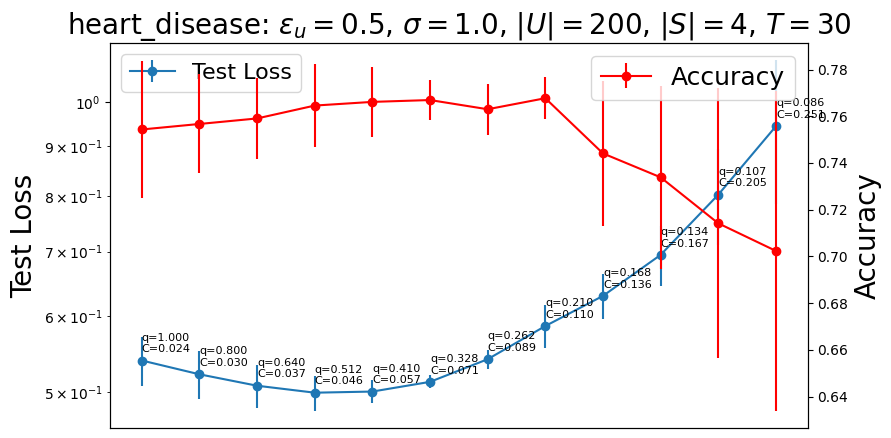

{0.5: 3} 0.49971715211868284
Result image saved to: /Users/fumiyuki/research/AcSilo/acsilo/exp/img/static_optimization_result-1d-heart_disease-uniform-users-400.png


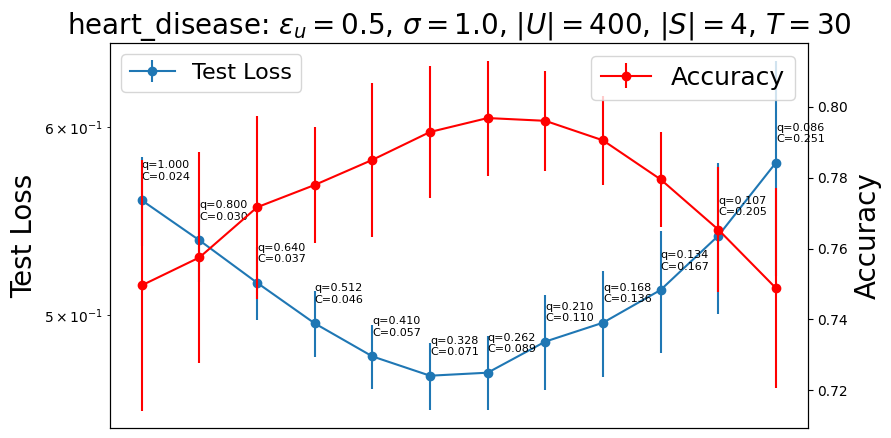

{0.5: 5} 0.4715245306491852


In [ ]:
sigma = 1.0
epsilon_list = [0.5]
group_thresholds = [0.5]
ratio_list = [1.0]
delta = 1e-5
n_round = 30
dataset_name = 'heart_disease'
q_step_size = 0.8
times = 5
validation_ratio = 0.0

for n_users in [50, 100, 200, 400]:
    random_state = np.random.RandomState(0)
    epsilon_u = make_epsilon_u(n_users=n_users, dist="hetero", epsilon_list=epsilon_list, ratio_list=ratio_list, random_state=random_state)
    grouped = group_by_closest_below(epsilon_u_dct=epsilon_u, group_thresholds=group_thresholds)
    epsilon_u = {}
    for eps_u, user_ids in grouped.items():
        for user_id in user_ids:
            epsilon_u[user_id] = eps_u
    opt_strategy = prepare_grid_search(epsilon_u, start_idx=0, end_idx=12)

    logger_set_warning()
    if not is_from_pickle:
        static_optimization(
            epsilon_u, sigma, delta, n_users, n_round, dataset_name, times, 
            q_step_size, opt_strategy=opt_strategy, global_learning_rate=10.0, 
            local_learning_rate=0.001, local_epochs=30, 
            validation_ratio=validation_ratio, user_dist="uniform-iid", silo_dist="uniform",
        )
    min_idx, min_loss = show_static_optimization_result(
        epsilon_u, sigma, delta, n_users, n_round, dataset_name, 
        q_step_size, n_silos=4, opt_strategy=opt_strategy, 
        validation_ratio=validation_ratio, train_loss=False, user_dist="uniform-iid",
        img_name=f"heart_disease-uniform-users-{n_users}", global_learning_rate=10.0, local_learning_rate=0.001, local_epochs=30
    )
    print(min_idx, min_loss)

#### Various eps_u with a single eps group (Fig in Sec4)

Result image saved to: /Users/fumiyuki/research/AcSilo/acsilo/exp/img/static_optimization_result-1d-heart_disease-uniform-eps-0.5.png


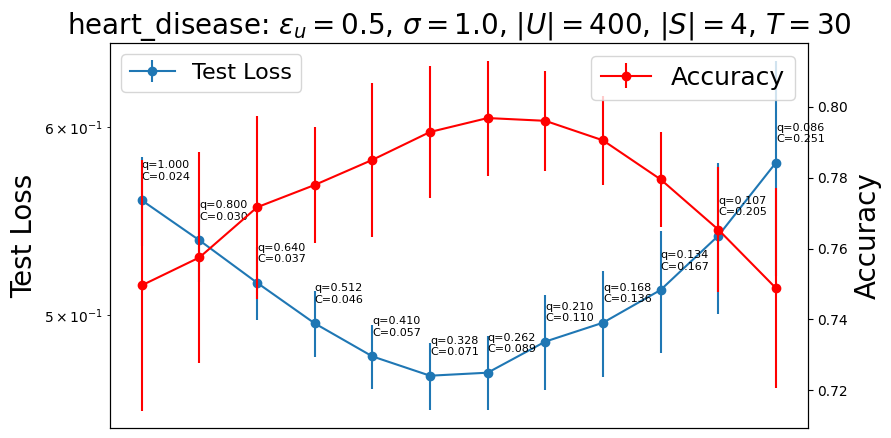

{0.5: 5} 0.4715245306491852
Result image saved to: /Users/fumiyuki/research/AcSilo/acsilo/exp/img/static_optimization_result-1d-heart_disease-uniform-eps-1.0.png


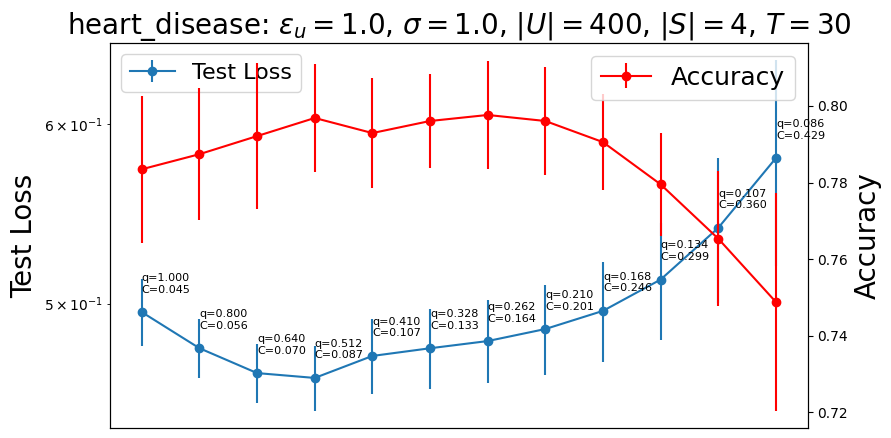

{1.0: 3} 0.46370276212692263
Result image saved to: /Users/fumiyuki/research/AcSilo/acsilo/exp/img/static_optimization_result-1d-heart_disease-uniform-eps-5.0.png


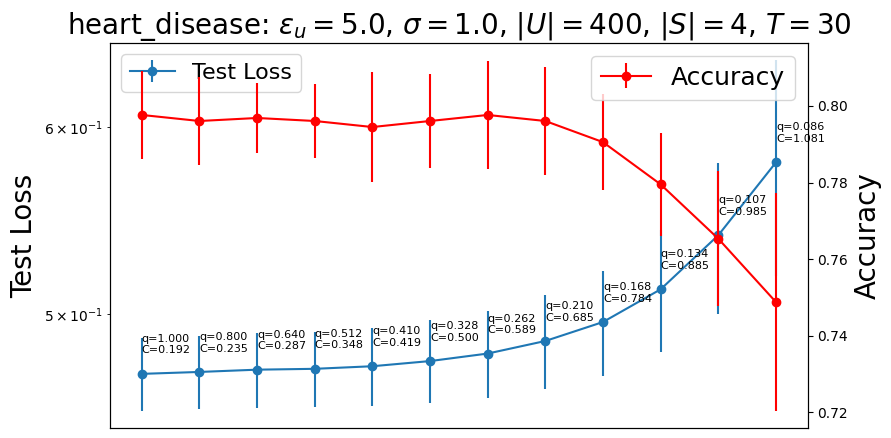

{5.0: 0} 0.4719789981842041


In [ ]:
sigma = 1.0
ratio_list = [1.0]
delta = 1e-5
n_round = 30
n_users = 400
dataset_name = 'heart_disease'
q_step_size = 0.8
times = 5
validation_ratio = 0.0

for eps_u in [0.5, 1.0, 5.0]:
    epsilon_list = [eps_u]
    group_thresholds = [eps_u]
    random_state = np.random.RandomState(0)
    epsilon_u = make_epsilon_u(n_users=n_users, dist="hetero", epsilon_list=epsilon_list, ratio_list=ratio_list, random_state=random_state)
    grouped = group_by_closest_below(epsilon_u_dct=epsilon_u, group_thresholds=group_thresholds)
    epsilon_u = {}
    for eps_u, user_ids in grouped.items():
        for user_id in user_ids:
            epsilon_u[user_id] = eps_u
    opt_strategy = prepare_grid_search(epsilon_u, start_idx=0, end_idx=12)

    logger_set_warning()
    if not is_from_pickle:
        static_optimization(
            epsilon_u, sigma, delta, n_users, n_round, dataset_name, times, 
            q_step_size, opt_strategy=opt_strategy, global_learning_rate=10.0, 
            local_learning_rate=0.001, local_epochs=30, 
            validation_ratio=validation_ratio, user_dist="uniform-iid", silo_dist="uniform",
        )
    min_idx, min_loss = show_static_optimization_result(
        epsilon_u, sigma, delta, n_users, n_round, dataset_name, 
        q_step_size, n_silos=4, opt_strategy=opt_strategy, validation_ratio=validation_ratio,
        train_loss=False, img_name=f"heart_disease-uniform-eps-{epsilon_list[0]}", user_dist="uniform-iid",
        global_learning_rate=10.0, local_learning_rate=0.001, local_epochs=30
    )
    print(min_idx, min_loss)

#### for ULDP-AVG

Result image saved to: /Users/fumiyuki/research/AcSilo/acsilo/exp/img/static_optimization_result-1d-heart_disease-uldpavg.png


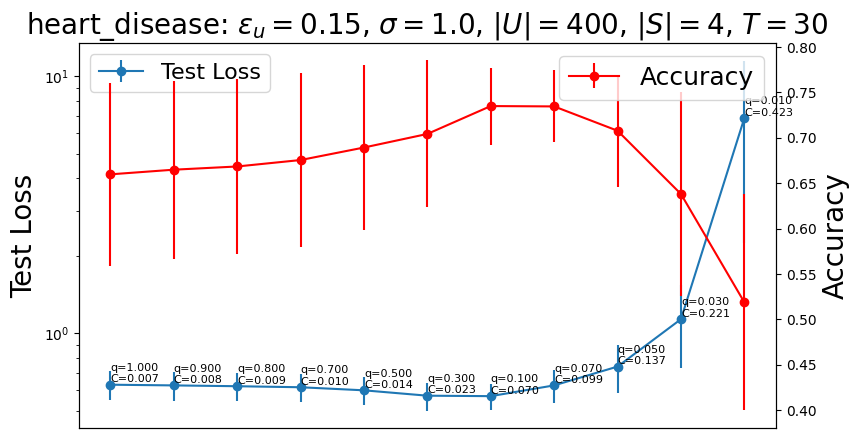

min_idx = {0.15: 6}, min_loss = 0.5696709662675857


In [ ]:
sigma = 1.0
n_users = 400
epsilon_list = [0.15]
group_thresholds = epsilon_list
ratio_list = [1.0]
delta = 1e-5
n_round = 30
dataset_name = 'heart_disease'
q_step_size = 0.0
times = 10
validation_ratio = 0.0
static_q_u_list = [1.0, 0.9, 0.8, 0.7, 0.5, 0.3, 0.1, 0.07, 0.05, 0.03, 0.01]

random_state = np.random.RandomState(0)
epsilon_u = make_epsilon_u(n_users=n_users, dist="hetero", epsilon_list=epsilon_list, ratio_list=ratio_list, random_state=random_state)
grouped = group_by_closest_below(epsilon_u_dct=epsilon_u, group_thresholds=group_thresholds)
epsilon_u = {}
for eps_u, user_ids in grouped.items():
    for user_id in user_ids:
        epsilon_u[user_id] = eps_u
opt_strategy = prepare_grid_search(epsilon_u, start_idx=0, end_idx=11)

logger_set_warning()
if not is_from_pickle:
    static_optimization(
        epsilon_u, sigma, delta, n_users, n_round, dataset_name, times, 
        q_step_size, opt_strategy=opt_strategy, global_learning_rate=10.0, 
        local_learning_rate=0.001, local_epochs=30, validation_ratio=validation_ratio, 
        user_dist="uniform-iid", silo_dist="uniform", 
        static_q_u_list=static_q_u_list
    )
min_idx, min_loss = show_static_optimization_result(
    epsilon_u, sigma, delta, n_users, n_round, dataset_name, 
    q_step_size, n_silos=4, opt_strategy=opt_strategy, validation_ratio=validation_ratio,
    train_loss=False, img_name=f"{dataset_name}-uldpavg", is_3d=False, 
    static_q_u_list=static_q_u_list, user_dist="uniform-iid",
    global_learning_rate=10.0, local_learning_rate=0.001, local_epochs=30
)
print(f"min_idx = {min_idx}, min_loss = {min_loss}")

## Online HPO

### HeartDisease

In [3]:
hd_all_acc_results = {}

#### QCTest

Result image saved to: /Users/fumiyuki/research/AcSilo/acsilo/exp/img/online_optimization_result-heart_disease-PULDP-AVG-QCTest-0.1.png


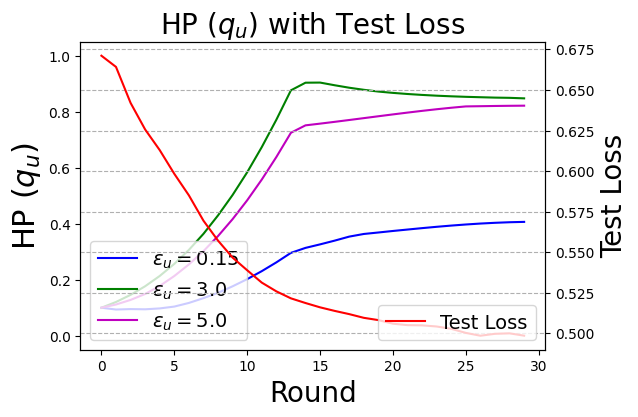

Result image saved to: /Users/fumiyuki/research/AcSilo/acsilo/exp/img/online_optimization_result-losses-heart_disease-PULDP-AVG-QCTest-0.1.png


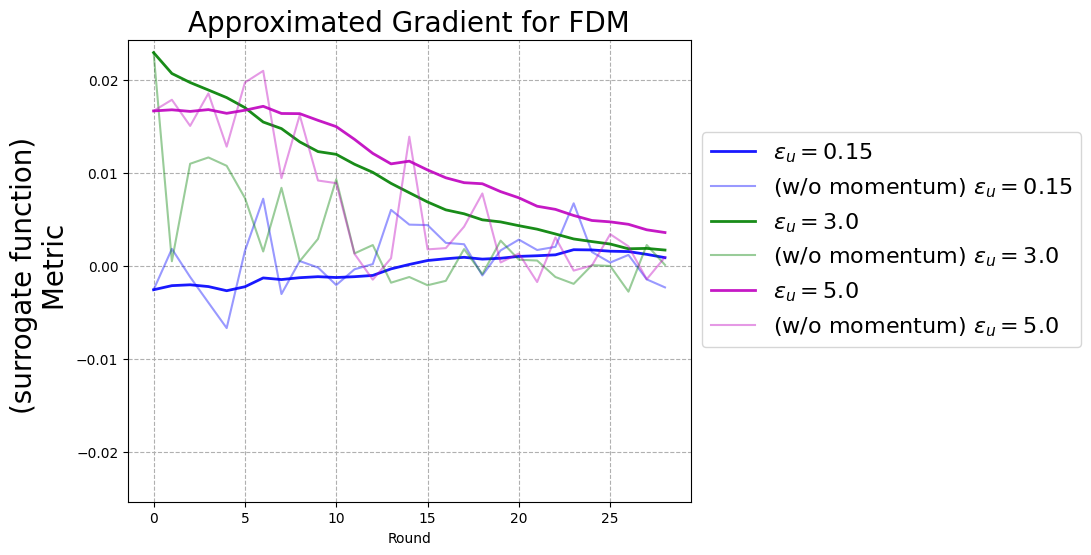

Result image saved to: /Users/fumiyuki/research/AcSilo/acsilo/exp/img/online_optimization_result-heart_disease-PULDP-AVG-QCTest-0.5.png


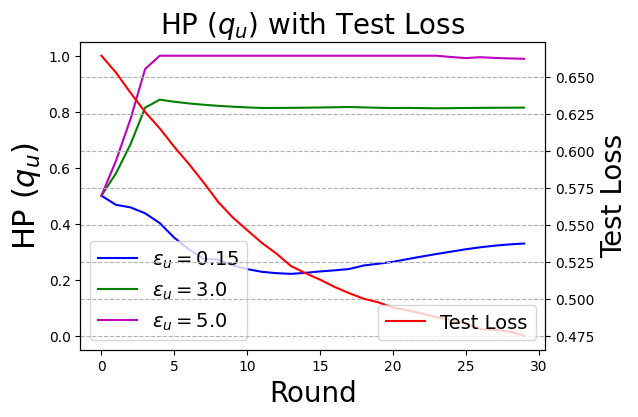

Result image saved to: /Users/fumiyuki/research/AcSilo/acsilo/exp/img/online_optimization_result-losses-heart_disease-PULDP-AVG-QCTest-0.5.png


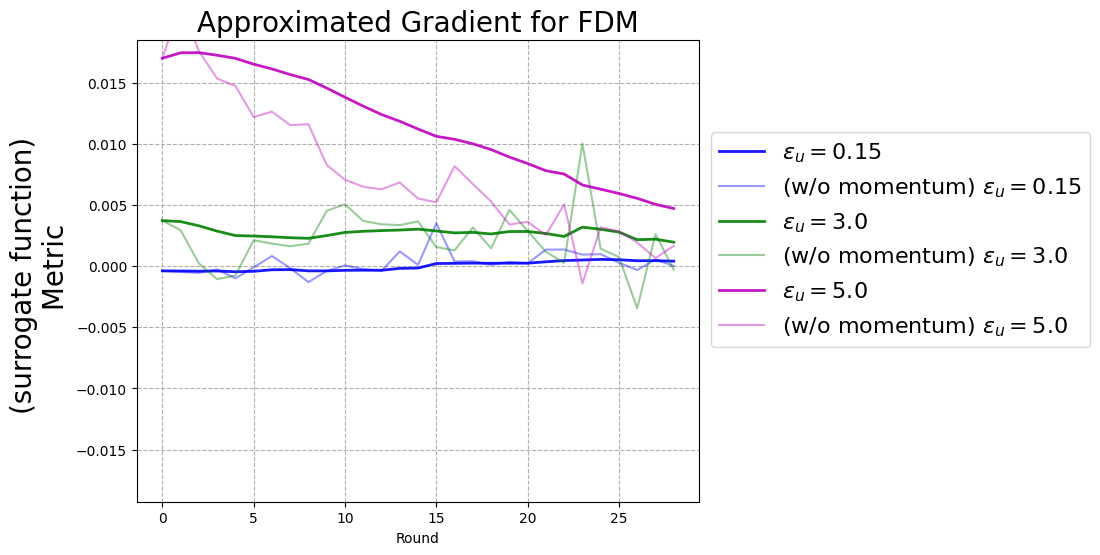

Result image saved to: /Users/fumiyuki/research/AcSilo/acsilo/exp/img/online_optimization_result-heart_disease-PULDP-AVG-QCTest-1.0.png


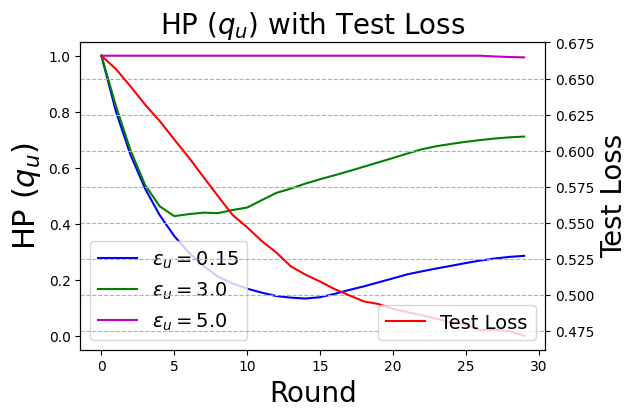

Result image saved to: /Users/fumiyuki/research/AcSilo/acsilo/exp/img/online_optimization_result-losses-heart_disease-PULDP-AVG-QCTest-1.0.png


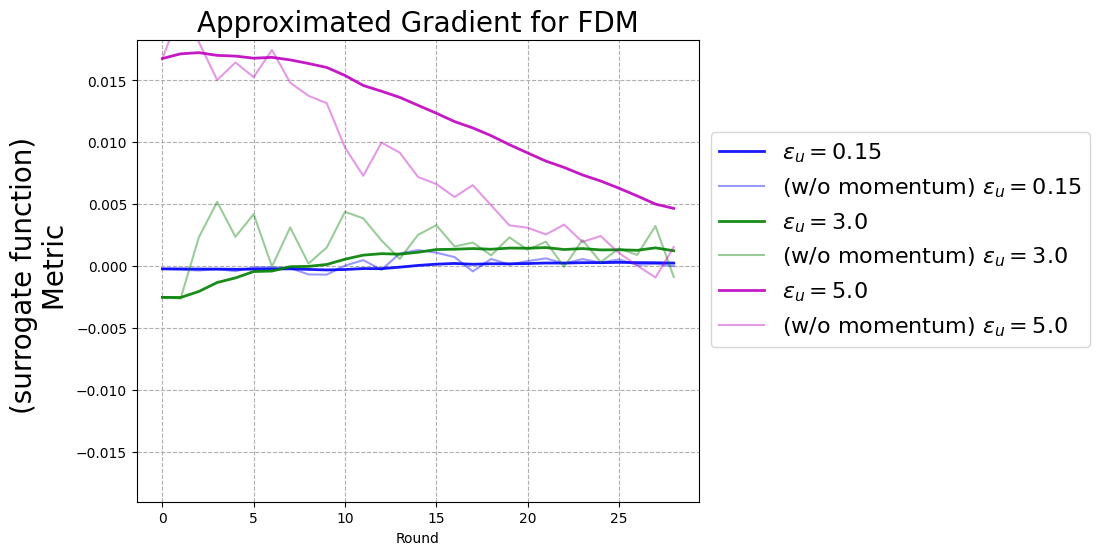

In [ ]:
n_users = 400
sigma = 1.0
epsilon_list = [0.15, 3.0, 5.0]
group_thresholds = epsilon_list
ratio_list = [0.6, 0.25, 0.15]
delta = 1e-5
n_round = 30
dataset_name = 'heart_disease'
q_step_size = 0.8
initial_q_u_list = [0.1, 0.5, 1.0]
validation_ratio = 0.5
times = 10
agg_strategy = "PULDP-AVG-QCTest"
with_momentum = True
step_decay = True
hp_baseline = None

logger_set_warning()

for initial_q_u in initial_q_u_list:
    random_state = np.random.RandomState(0)
    epsilon_u_dct = make_epsilon_u(n_users=n_users, dist="hetero", epsilon_list=epsilon_list, ratio_list=ratio_list, random_state=random_state)
    grouped = group_by_closest_below(epsilon_u_dct=epsilon_u_dct, group_thresholds=group_thresholds)
    epsilon_u = {}
    for eps_u, user_ids in grouped.items():
        for user_id in user_ids:
            epsilon_u[user_id] = eps_u
    if not is_from_pickle:
        run_online_optimization(
            epsilon_u, sigma, delta, n_users, n_round, dataset_name, q_step_size, 
            group_thresholds, times, global_learning_rate=10.0, local_learning_rate=0.001, 
            local_epochs=30, validation_ratio=validation_ratio, agg_strategy=agg_strategy, 
            with_momentum=with_momentum, step_decay=step_decay, hp_baseline=hp_baseline,
            user_dist="uniform-iid", silo_dist="uniform", initial_q_u=initial_q_u,
        )
    x, acc_means, acc_stds = show_online_optimization_result(
        epsilon_u, sigma, delta, n_users, n_round, dataset_name, q_step_size, 
        validation_ratio=validation_ratio, agg_strategy=agg_strategy, with_momentum=with_momentum,  initial_q_u=initial_q_u,
        step_decay=step_decay, hp_baseline=hp_baseline, errorbar=False, img_name=f"{dataset_name}-{agg_strategy}-{initial_q_u}",
        global_learning_rate=10.0, local_learning_rate=0.001, local_epochs=30
    )

    hd_all_acc_results[(agg_strategy, initial_q_u)] = (x, acc_means, acc_stds)

##### different (bigger) step size

======== TIME: 0 start
======== TIME: 1 start
======== TIME: 2 start
======== TIME: 3 start
======== TIME: 4 start
======== TIME: 5 start
======== TIME: 6 start
======== TIME: 7 start
======== TIME: 8 start
======== TIME: 9 start
TEST ACC: 0.7591 ± 0.0678 , TEST LOSS: 0.5037 ± 0.0633
VALID ACC: 0.7795 ± 0.0645 , VALID LOSS: 0.4868 ± 0.0743
Result image saved to: /Users/fumiyuki/research/AcSilo/acsilo/exp/img/online_optimization_result-heart_disease-PULDP-AVG-QCTest-0.1.png


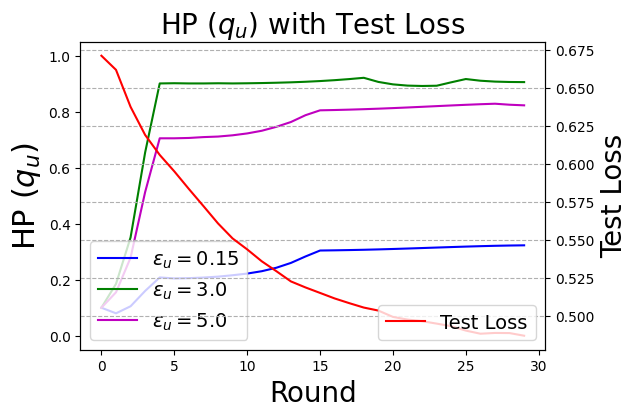

Result image saved to: /Users/fumiyuki/research/AcSilo/acsilo/exp/img/online_optimization_result-losses-heart_disease-PULDP-AVG-QCTest-0.1.png


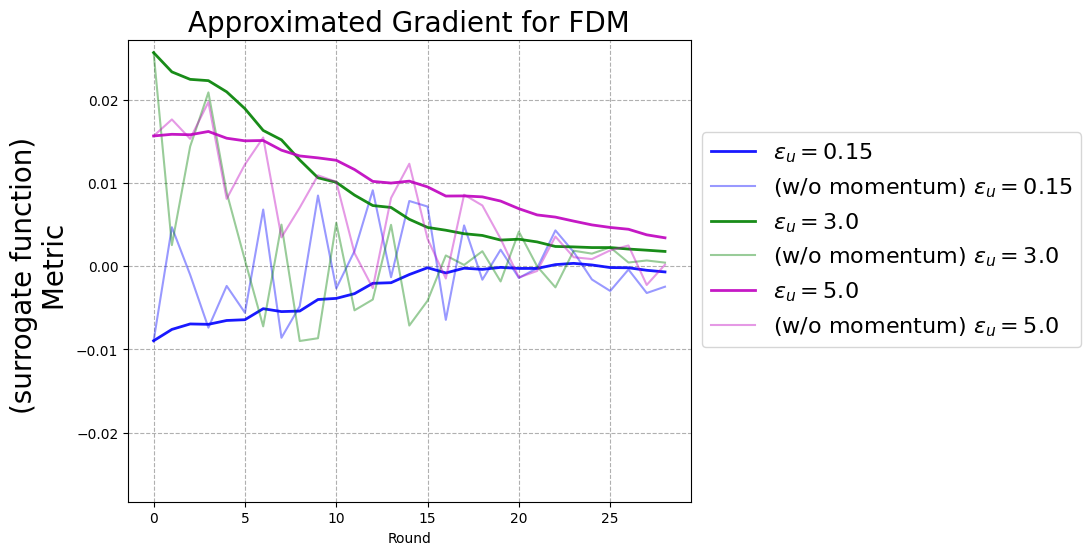

======== TIME: 0 start
======== TIME: 1 start
======== TIME: 2 start
======== TIME: 3 start
======== TIME: 4 start
======== TIME: 5 start
======== TIME: 6 start
======== TIME: 7 start
======== TIME: 8 start
======== TIME: 9 start
TEST ACC: 0.7646 ± 0.0272 , TEST LOSS: 0.4787 ± 0.0418
VALID ACC: 0.8000 ± 0.0315 , VALID LOSS: 0.4734 ± 0.0446
Result image saved to: /Users/fumiyuki/research/AcSilo/acsilo/exp/img/online_optimization_result-heart_disease-PULDP-AVG-QCTest-0.5.png


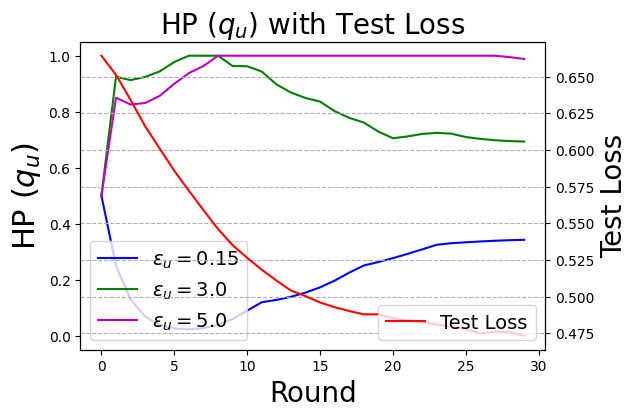

Result image saved to: /Users/fumiyuki/research/AcSilo/acsilo/exp/img/online_optimization_result-losses-heart_disease-PULDP-AVG-QCTest-0.5.png


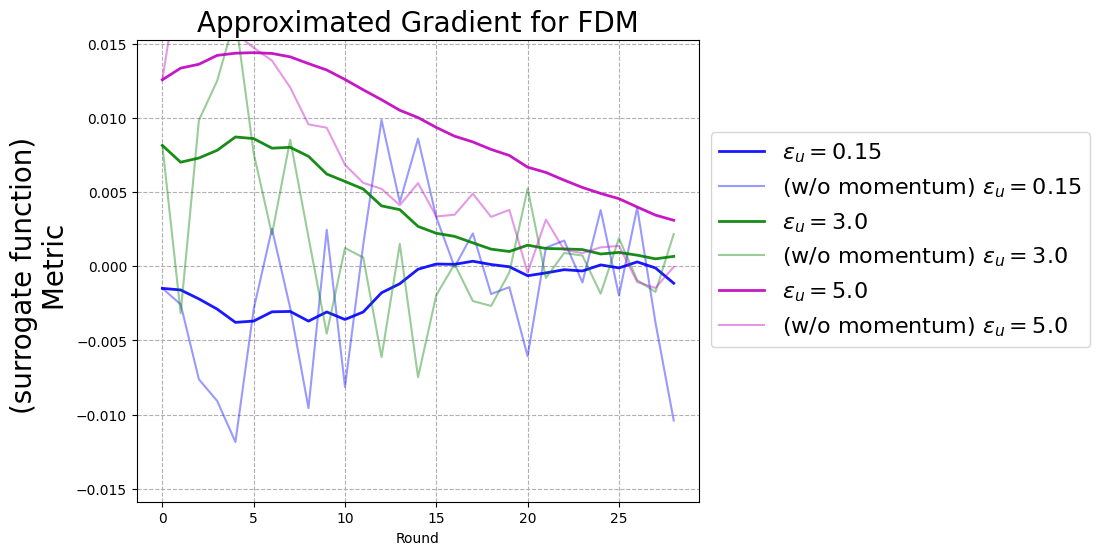

======== TIME: 0 start
======== TIME: 1 start
======== TIME: 2 start
======== TIME: 3 start
======== TIME: 4 start
======== TIME: 5 start
======== TIME: 6 start
======== TIME: 7 start
======== TIME: 8 start
======== TIME: 9 start
TEST ACC: 0.7685 ± 0.0278 , TEST LOSS: 0.4891 ± 0.0390
VALID ACC: 0.7969 ± 0.0354 , VALID LOSS: 0.4803 ± 0.0521
Result image saved to: /Users/fumiyuki/research/AcSilo/acsilo/exp/img/online_optimization_result-heart_disease-PULDP-AVG-QCTest-1.0.png


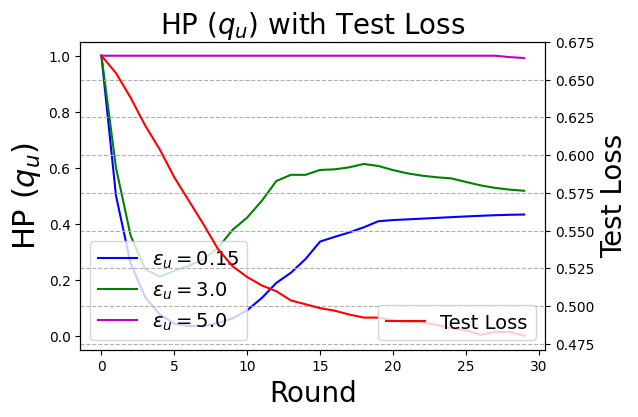

Result image saved to: /Users/fumiyuki/research/AcSilo/acsilo/exp/img/online_optimization_result-losses-heart_disease-PULDP-AVG-QCTest-1.0.png


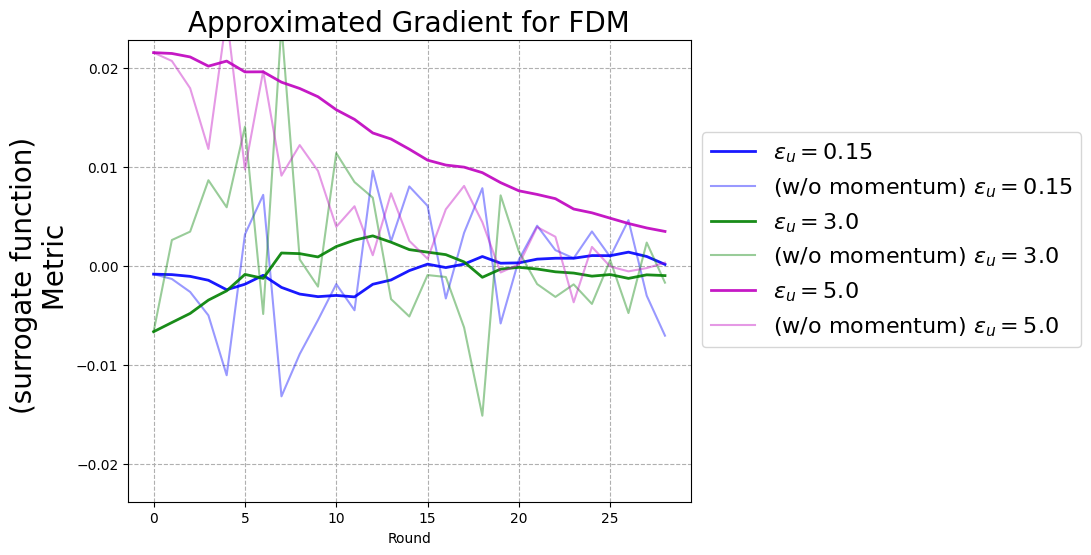

In [ ]:
n_users = 400
sigma = 1.0
epsilon_list = [0.15, 3.0, 5.0]
group_thresholds = epsilon_list
ratio_list = [0.6, 0.25, 0.15]
delta = 1e-5
n_round = 30
dataset_name = 'heart_disease'
q_step_size = 0.5
initial_q_u_list = [0.1, 0.5, 1.0]
validation_ratio = 0.5
times = 10
agg_strategy = "PULDP-AVG-QCTest"
with_momentum = True
step_decay = True
hp_baseline = None

logger_set_warning()

for initial_q_u in initial_q_u_list:
    random_state = np.random.RandomState(0)
    epsilon_u_dct = make_epsilon_u(n_users=n_users, dist="hetero", epsilon_list=epsilon_list, ratio_list=ratio_list, random_state=random_state)
    grouped = group_by_closest_below(epsilon_u_dct=epsilon_u_dct, group_thresholds=group_thresholds)
    epsilon_u = {}
    for eps_u, user_ids in grouped.items():
        for user_id in user_ids:
            epsilon_u[user_id] = eps_u
    if not is_from_pickle:
        run_online_optimization(
            epsilon_u, sigma, delta, n_users, n_round, dataset_name, q_step_size, 
            group_thresholds, times, global_learning_rate=10.0, local_learning_rate=0.001, 
            local_epochs=30, validation_ratio=validation_ratio, agg_strategy=agg_strategy, 
            with_momentum=with_momentum, step_decay=step_decay, hp_baseline=hp_baseline,
            user_dist="uniform-iid", silo_dist="uniform", initial_q_u=initial_q_u,
        )
    x, acc_means, acc_stds = show_online_optimization_result(
        epsilon_u, sigma, delta, n_users, n_round, dataset_name, q_step_size, 
        validation_ratio=validation_ratio, agg_strategy=agg_strategy, with_momentum=with_momentum,  initial_q_u=initial_q_u,
        step_decay=step_decay, hp_baseline=hp_baseline, errorbar=False, img_name=f"{dataset_name}-{agg_strategy}-{initial_q_u}",
        global_learning_rate=10.0, local_learning_rate=0.001, local_epochs=30
    )

    hd_all_acc_results[(agg_strategy, initial_q_u)] = (x, acc_means, acc_stds)

#### QCTrain

Result image saved to: /Users/fumiyuki/research/AcSilo/acsilo/exp/img/online_optimization_result-heart_disease-PULDP-AVG-QCTrain-0.1-True.png


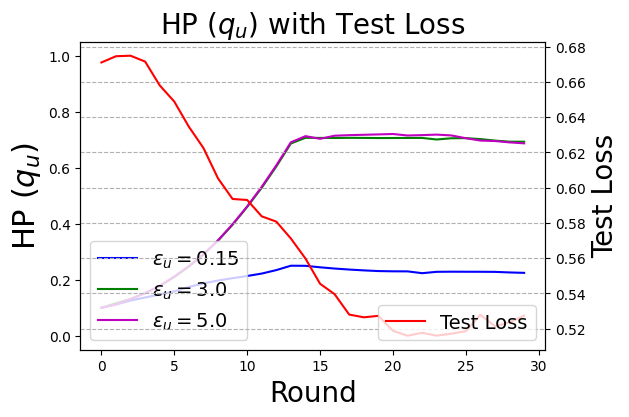

Result image saved to: /Users/fumiyuki/research/AcSilo/acsilo/exp/img/online_optimization_result-losses-heart_disease-PULDP-AVG-QCTrain-0.1-True.png


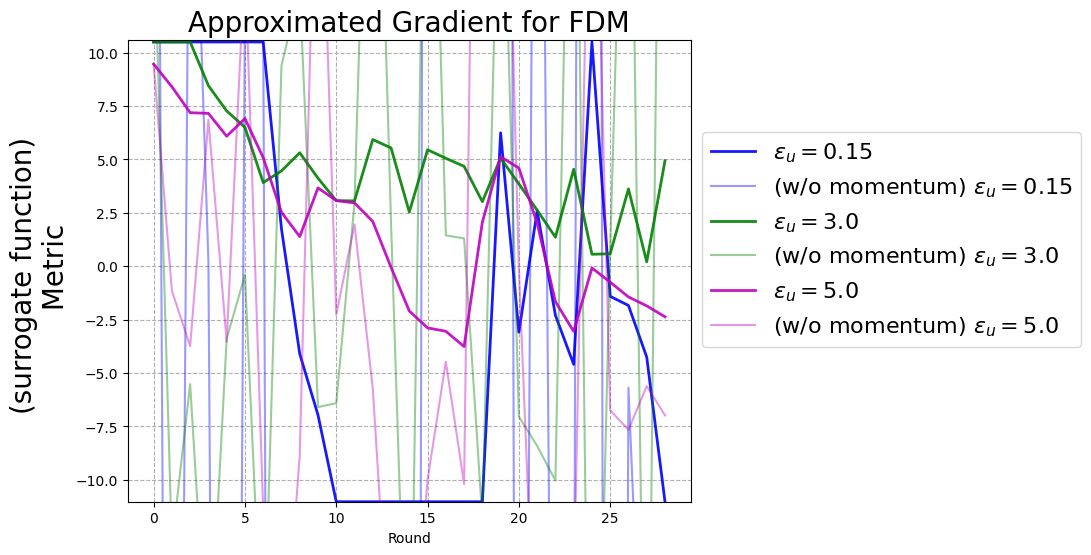

Result image saved to: /Users/fumiyuki/research/AcSilo/acsilo/exp/img/online_optimization_result-heart_disease-PULDP-AVG-QCTrain-0.5-True.png


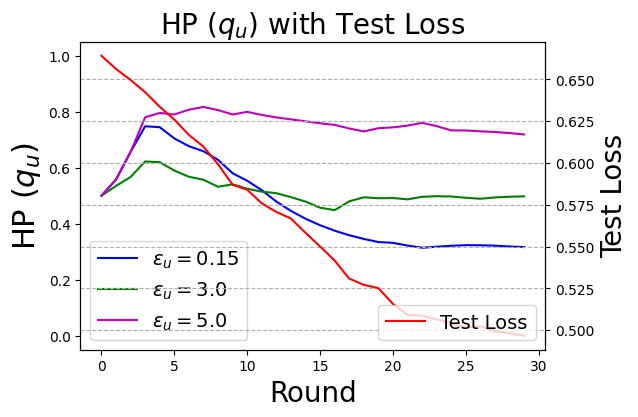

Result image saved to: /Users/fumiyuki/research/AcSilo/acsilo/exp/img/online_optimization_result-losses-heart_disease-PULDP-AVG-QCTrain-0.5-True.png


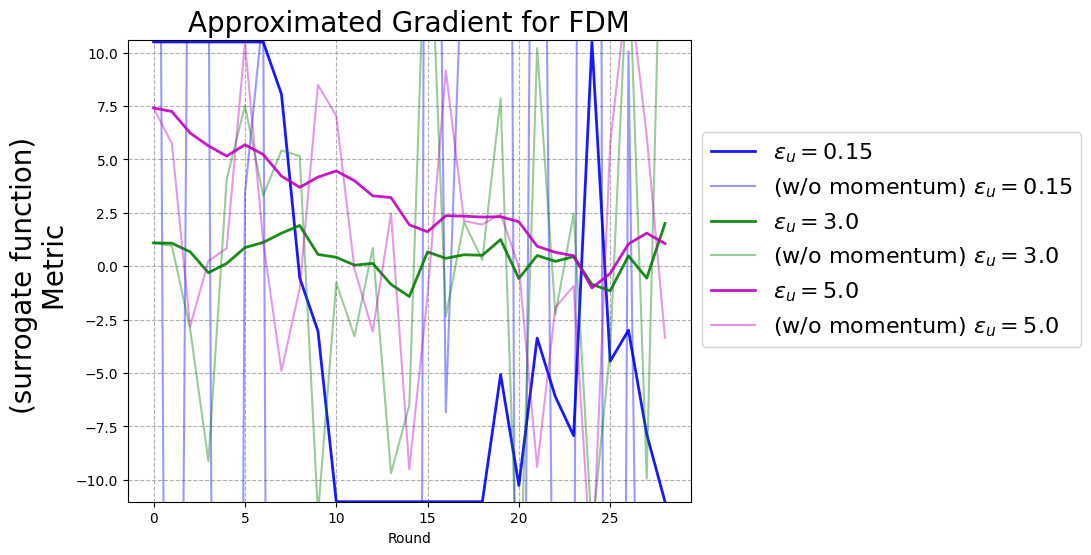

Result image saved to: /Users/fumiyuki/research/AcSilo/acsilo/exp/img/online_optimization_result-heart_disease-PULDP-AVG-QCTrain-1.0-True.png


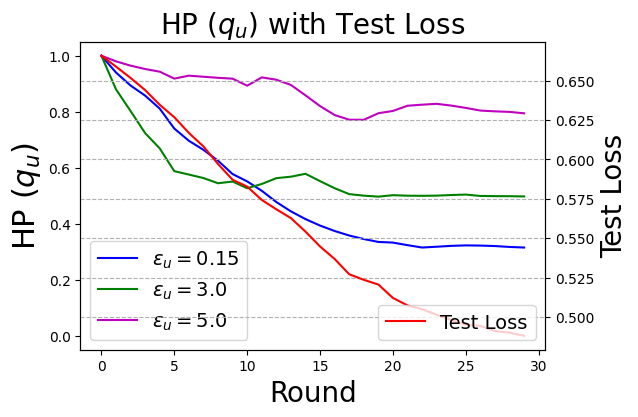

Result image saved to: /Users/fumiyuki/research/AcSilo/acsilo/exp/img/online_optimization_result-losses-heart_disease-PULDP-AVG-QCTrain-1.0-True.png


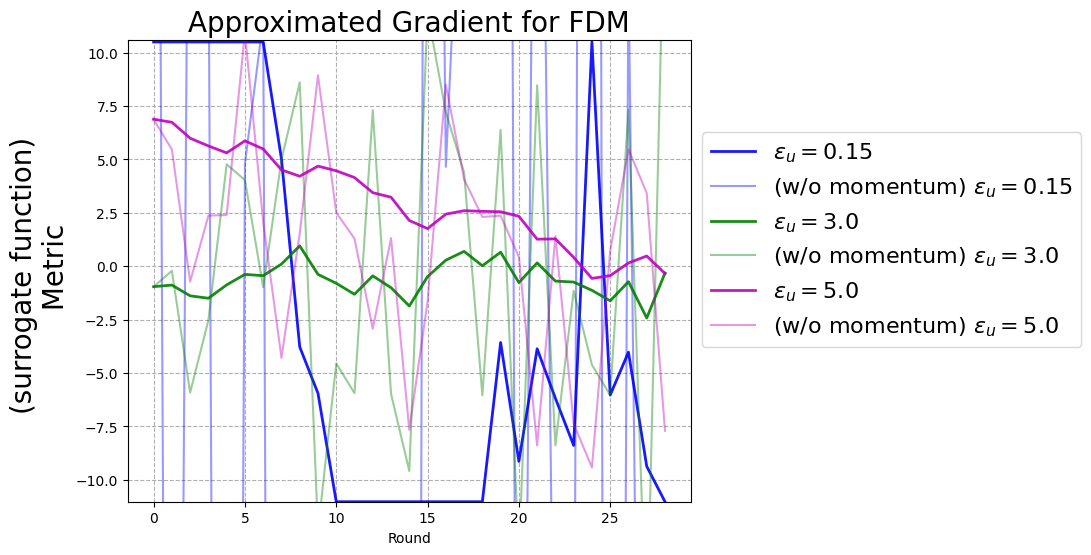

In [ ]:
n_users = 400
sigma = 1.0
epsilon_list = [0.15, 3.0, 5.0]
group_thresholds = epsilon_list
ratio_list = [0.6, 0.25, 0.15]
delta = 1e-5
n_round = 30
dataset_name = 'heart_disease'
q_step_size = 0.8
initial_q_u_list = [0.1, 0.5, 1.0]
validation_ratio = 0.5
times = 10
agg_strategy = "PULDP-AVG-QCTrain"
with_momentum = True
step_decay = True
hp_baseline = None

logger_set_warning()

for initial_q_u in initial_q_u_list:
    random_state = np.random.RandomState(0)
    epsilon_u_dct = make_epsilon_u(n_users=n_users, dist="hetero", epsilon_list=epsilon_list, ratio_list=ratio_list, random_state=random_state)
    grouped = group_by_closest_below(epsilon_u_dct=epsilon_u_dct, group_thresholds=group_thresholds)
    epsilon_u = {}
    for eps_u, user_ids in grouped.items():
        for user_id in user_ids:
            epsilon_u[user_id] = eps_u
    if not is_from_pickle:
        run_online_optimization(
            epsilon_u, sigma, delta, n_users, n_round, dataset_name, q_step_size, 
            group_thresholds, times, global_learning_rate=10.0, local_learning_rate=0.001, 
            local_epochs=30, validation_ratio=validation_ratio, agg_strategy=agg_strategy, 
            with_momentum=with_momentum, step_decay=step_decay, hp_baseline=hp_baseline,
            user_dist="uniform-iid", silo_dist="uniform", initial_q_u=initial_q_u,
        )
    x, acc_means, acc_stds = show_online_optimization_result(
        epsilon_u, sigma, delta, n_users, n_round, dataset_name, q_step_size, 
        validation_ratio=validation_ratio, agg_strategy=agg_strategy, with_momentum=with_momentum, initial_q_u=initial_q_u,
        step_decay=step_decay, hp_baseline=hp_baseline, errorbar=False, img_name=f"{dataset_name}-{agg_strategy}-{initial_q_u}-{step_decay}",
        global_learning_rate=10.0, local_learning_rate=0.001, local_epochs=30
    )
    hd_all_acc_results[(agg_strategy, initial_q_u)] = (x, acc_means, acc_stds)

##### ablation study: weight decay

Result image saved to: /Users/fumiyuki/research/AcSilo/acsilo/exp/img/online_optimization_result-heart_disease-PULDP-AVG-QCTrain-0.1-False.png


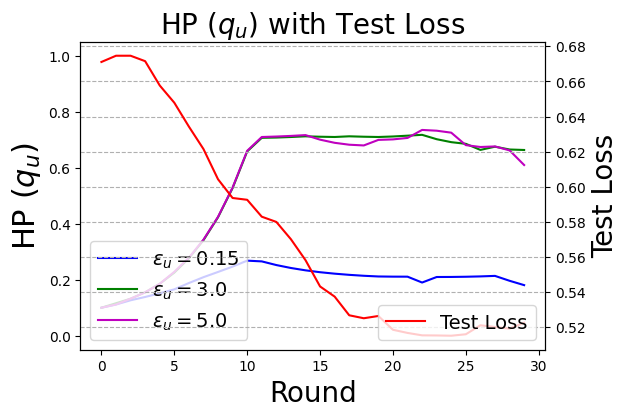

Result image saved to: /Users/fumiyuki/research/AcSilo/acsilo/exp/img/online_optimization_result-losses-heart_disease-PULDP-AVG-QCTrain-0.1-False.png


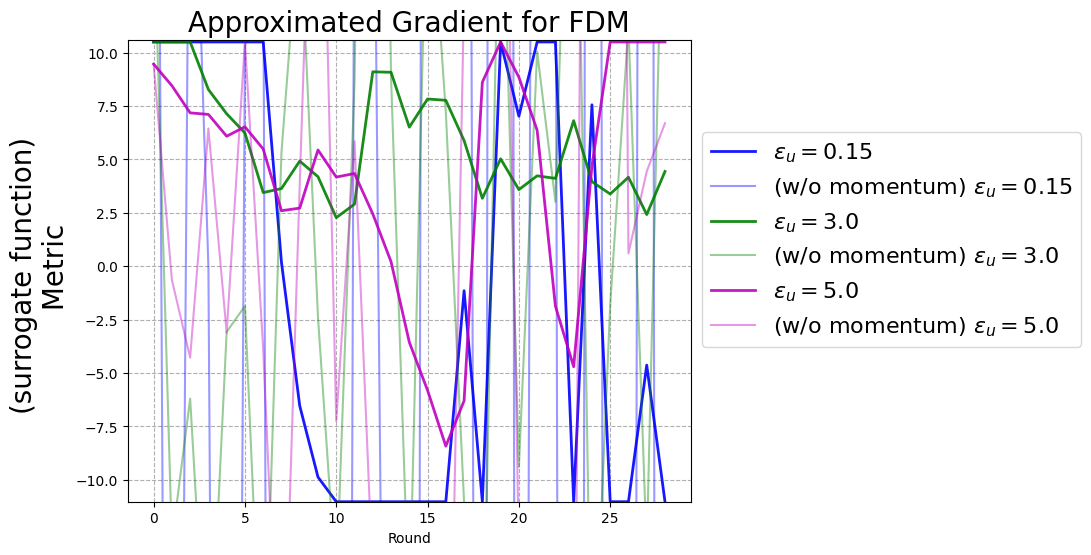

Result image saved to: /Users/fumiyuki/research/AcSilo/acsilo/exp/img/online_optimization_result-heart_disease-PULDP-AVG-QCTrain-0.5-False.png


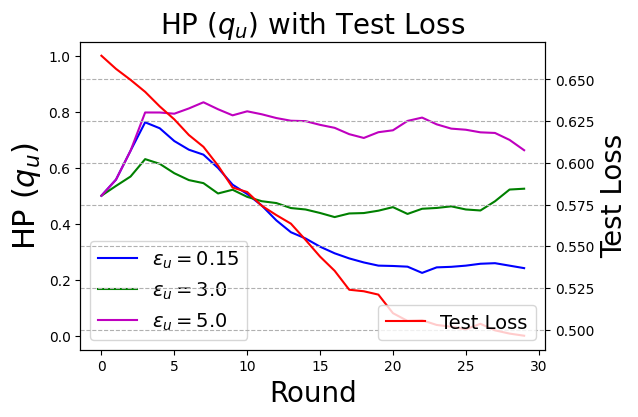

Result image saved to: /Users/fumiyuki/research/AcSilo/acsilo/exp/img/online_optimization_result-losses-heart_disease-PULDP-AVG-QCTrain-0.5-False.png


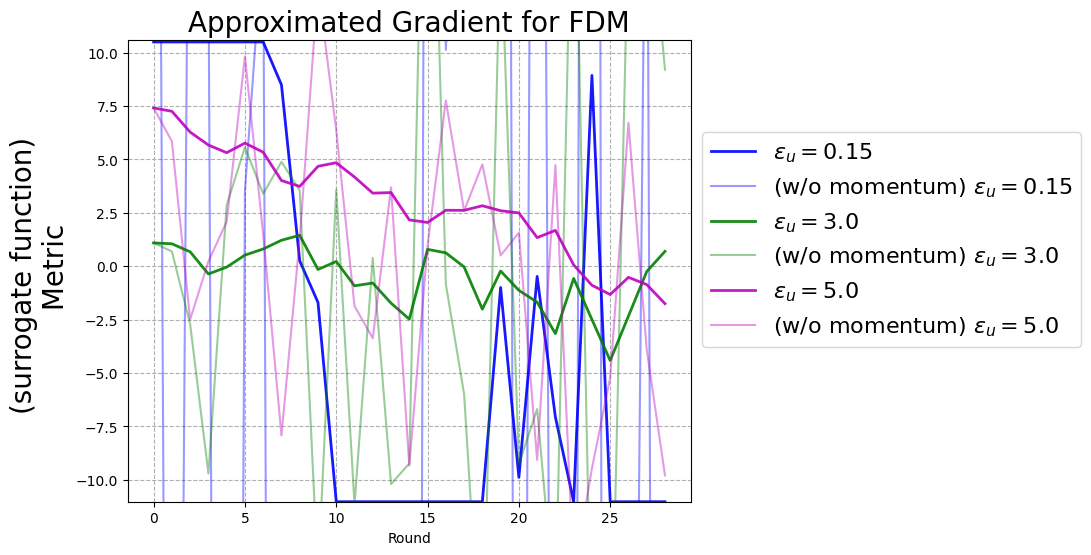

Result image saved to: /Users/fumiyuki/research/AcSilo/acsilo/exp/img/online_optimization_result-heart_disease-PULDP-AVG-QCTrain-1.0-False.png


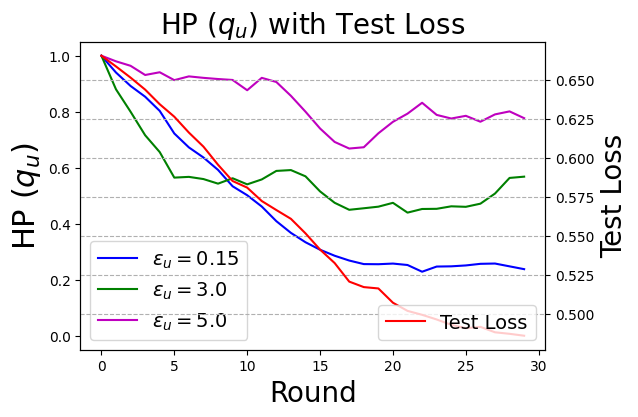

Result image saved to: /Users/fumiyuki/research/AcSilo/acsilo/exp/img/online_optimization_result-losses-heart_disease-PULDP-AVG-QCTrain-1.0-False.png


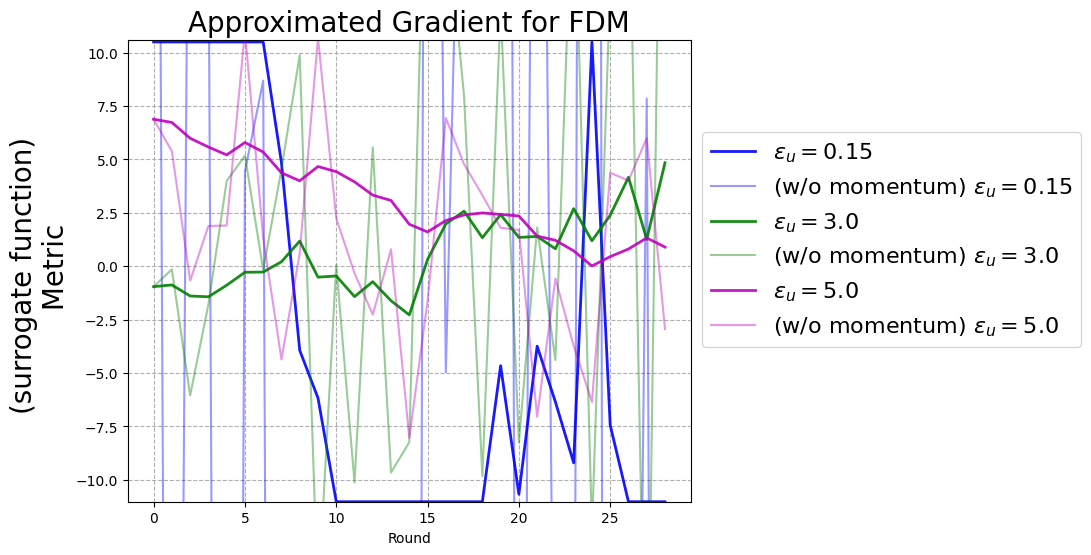

In [ ]:
n_users = 400
sigma = 1.0
epsilon_list = [0.15, 3.0, 5.0]
group_thresholds = epsilon_list
ratio_list = [0.6, 0.25, 0.15]
delta = 1e-5
n_round = 30
dataset_name = 'heart_disease'
q_step_size = 0.8
initial_q_u_list = [0.1, 0.5, 1.0]
validation_ratio = 0.5
times = 10
agg_strategy = "PULDP-AVG-QCTrain"
with_momentum = True
step_decay = False
hp_baseline = None

logger_set_warning()

for initial_q_u in initial_q_u_list:
    random_state = np.random.RandomState(0)
    epsilon_u_dct = make_epsilon_u(n_users=n_users, dist="hetero", epsilon_list=epsilon_list, ratio_list=ratio_list, random_state=random_state)
    grouped = group_by_closest_below(epsilon_u_dct=epsilon_u_dct, group_thresholds=group_thresholds)
    epsilon_u = {}
    for eps_u, user_ids in grouped.items():
        for user_id in user_ids:
            epsilon_u[user_id] = eps_u
    if not is_from_pickle:
        run_online_optimization(
            epsilon_u, sigma, delta, n_users, n_round, dataset_name, q_step_size, 
            group_thresholds, times, global_learning_rate=10.0, local_learning_rate=0.001, 
            local_epochs=30, validation_ratio=validation_ratio, agg_strategy=agg_strategy, 
            with_momentum=with_momentum, step_decay=step_decay, hp_baseline=hp_baseline,
            user_dist="uniform-iid", silo_dist="uniform", initial_q_u=initial_q_u,
        )
    x, acc_means, acc_stds = show_online_optimization_result(
        epsilon_u, sigma, delta, n_users, n_round, dataset_name, q_step_size, 
        validation_ratio=validation_ratio, agg_strategy=agg_strategy, with_momentum=with_momentum, initial_q_u=initial_q_u,
        step_decay=step_decay, hp_baseline=hp_baseline, errorbar=False, img_name=f"{dataset_name}-{agg_strategy}-{initial_q_u}-{step_decay}", 
        global_learning_rate=10.0, local_learning_rate=0.001, local_epochs=30
    )
    hd_all_acc_results[(agg_strategy, initial_q_u)] = (x, acc_means, acc_stds)

##### ablation study: momentum

======== TIME: 0 start
======== TIME: 1 start
======== TIME: 2 start
======== TIME: 3 start
======== TIME: 4 start
======== TIME: 5 start
======== TIME: 6 start
======== TIME: 7 start
======== TIME: 8 start
======== TIME: 9 start
TEST ACC: 0.7496 ± 0.0425 , TEST LOSS: 0.5462 ± 0.0595
VALID ACC: 0.7535 ± 0.0489 , VALID LOSS: 0.5618 ± 0.0923
Result image saved to: /Users/fumiyuki/research/AcSilo/acsilo/exp/img/online_optimization_result-heart_disease-PULDP-AVG-QCTrain-0.1-True.png


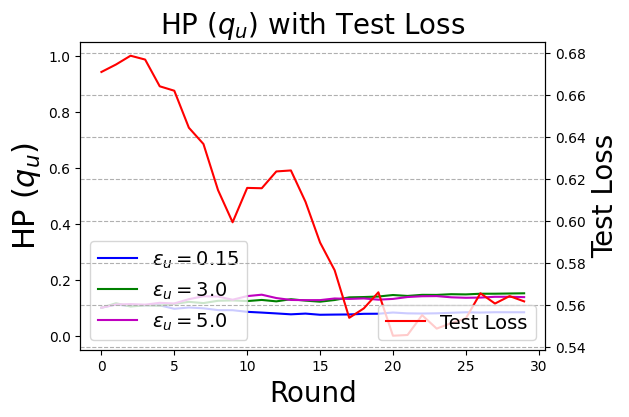

Result image saved to: /Users/fumiyuki/research/AcSilo/acsilo/exp/img/online_optimization_result-losses-heart_disease-PULDP-AVG-QCTrain-0.1-True.png


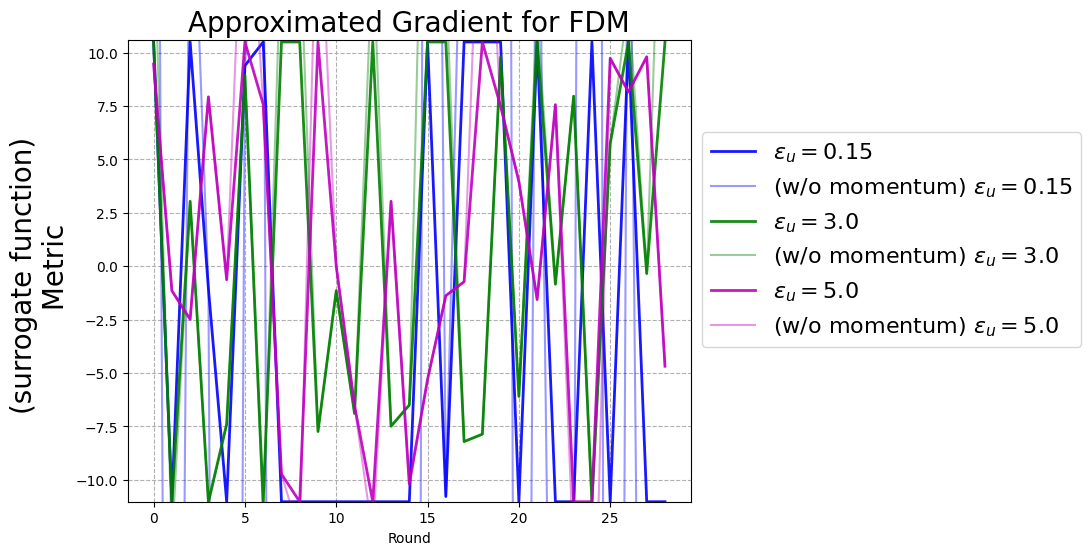

NameError: name 'hd_all_acc_results' is not defined

In [ ]:
n_users = 400
sigma = 1.0
epsilon_list = [0.15, 3.0, 5.0]
group_thresholds = epsilon_list
ratio_list = [0.6, 0.25, 0.15]
delta = 1e-5
n_round = 30
dataset_name = 'heart_disease'
q_step_size = 0.8
initial_q_u_list = [0.1, 0.5, 1.0]
validation_ratio = 0.5
times = 10
agg_strategy = "PULDP-AVG-QCTrain"
with_momentum = False
step_decay = True
hp_baseline = None

logger_set_warning()

for initial_q_u in initial_q_u_list:
    random_state = np.random.RandomState(0)
    epsilon_u_dct = make_epsilon_u(n_users=n_users, dist="hetero", epsilon_list=epsilon_list, ratio_list=ratio_list, random_state=random_state)
    grouped = group_by_closest_below(epsilon_u_dct=epsilon_u_dct, group_thresholds=group_thresholds)
    epsilon_u = {}
    for eps_u, user_ids in grouped.items():
        for user_id in user_ids:
            epsilon_u[user_id] = eps_u
    if not is_from_pickle:
        run_online_optimization(
            epsilon_u, sigma, delta, n_users, n_round, dataset_name, q_step_size, 
            group_thresholds, times, global_learning_rate=10.0, local_learning_rate=0.001, 
            local_epochs=30, validation_ratio=validation_ratio, agg_strategy=agg_strategy, 
            with_momentum=with_momentum, step_decay=step_decay, hp_baseline=hp_baseline,
            user_dist="uniform-iid", silo_dist="uniform", initial_q_u=initial_q_u,
        )
    x, acc_means, acc_stds = show_online_optimization_result(
        epsilon_u, sigma, delta, n_users, n_round, dataset_name, q_step_size, 
        validation_ratio=validation_ratio, agg_strategy=agg_strategy, with_momentum=with_momentum, initial_q_u=initial_q_u,
        step_decay=step_decay, hp_baseline=hp_baseline, errorbar=False, img_name=f"{dataset_name}-{agg_strategy}-{initial_q_u}-{step_decay}",
        global_learning_rate=10.0, local_learning_rate=0.001, local_epochs=30
    )
    hd_all_acc_results[(agg_strategy, initial_q_u)] = (x, acc_means, acc_stds)

#### Baselines

##### Best HP by static optimization (PULDP-AVG)
$(\epsilon_1, \epsilon_2, \epsilon_3) => (q_u=0.1, q_u=0.7, q_u=1.0)$

02/04/2024 10:53:14:WARNING:No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Result image saved to: /Users/fumiyuki/research/AcSilo/acsilo/exp/img/specified_idx_result-heart_disease-PULDPAVG.png


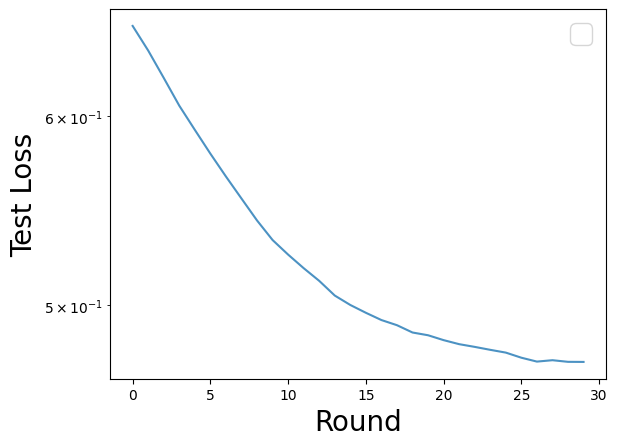

In [ ]:
n_users = 400
sigma = 1.0
epsilon_list = [0.15, 3.0, 5.0]
group_thresholds = epsilon_list
ratio_list = [0.6, 0.25, 0.15]
delta = 1e-5
n_round = 30
dataset_name = 'heart_disease'
q_step_size = 0.8
validation_ratio = 0.0
times = 10
random_state = np.random.RandomState(0)
agg_strategy = "PULDP-AVG"
with_momentum = True
step_decay = True
hp_baseline = None
static_q_u_list = [1.0, 0.9, 0.8, 0.7, 0.5, 0.3, 0.1]

logger_set_warning()

idx_per_group = {0.15: 6, 3.0: 3, 5.0: 0}
epsilon_u_dct = make_epsilon_u(n_users=n_users, dist="hetero", epsilon_list=epsilon_list, ratio_list=ratio_list, random_state=random_state)
grouped = group_by_closest_below(epsilon_u_dct=epsilon_u_dct, group_thresholds=group_thresholds)
epsilon_u = {}
for eps_u, user_ids in grouped.items():
    for user_id in user_ids:
        epsilon_u[user_id] = eps_u
prefix_epsilon_u = list(epsilon_u.items())[:4]

if not is_from_pickle:
    run_with_specified_idx(
        epsilon_u, sigma, delta, n_users, n_round, dataset_name, q_step_size, times, 
        static_q_u_list=static_q_u_list, user_dist="uniform-iid", silo_dist="uniform", validation_ratio=validation_ratio,
        idx_per_group=idx_per_group, global_learning_rate=10.0, local_learning_rate=0.001, local_epochs=30
    )
x, acc_means, acc_stds = show_specified_idx_result(
    prefix_epsilon_u, sigma, delta, n_users, n_round, dataset_name, q_step_size,
    idx_per_group, validation_ratio=validation_ratio, img_name=f"{dataset_name}-PULDPAVG", errorbar=False, static_q_u_list=static_q_u_list,
    global_learning_rate=10.0, local_learning_rate=0.001, local_epochs=30
)
hd_all_acc_results[(agg_strategy, "PULDP-AVG (Offline HPO)")] = (x, acc_means, acc_stds)

##### random-updown

Result image saved to: /Users/fumiyuki/research/AcSilo/acsilo/exp/img/online_optimization_result-heart_disease-PULDP-AVG-QCTrain-0.1-random-updown.png


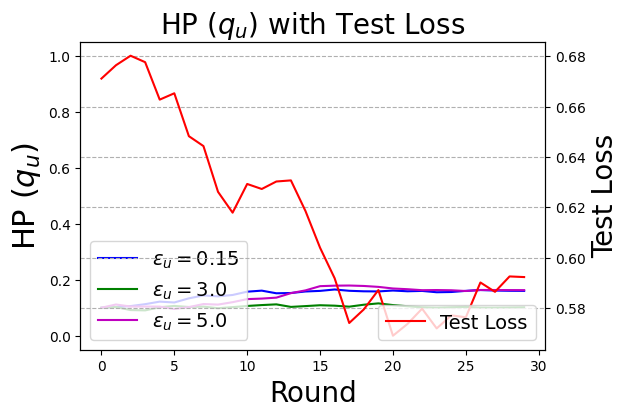

Result image saved to: /Users/fumiyuki/research/AcSilo/acsilo/exp/img/online_optimization_result-losses-heart_disease-PULDP-AVG-QCTrain-0.1-random-updown.png


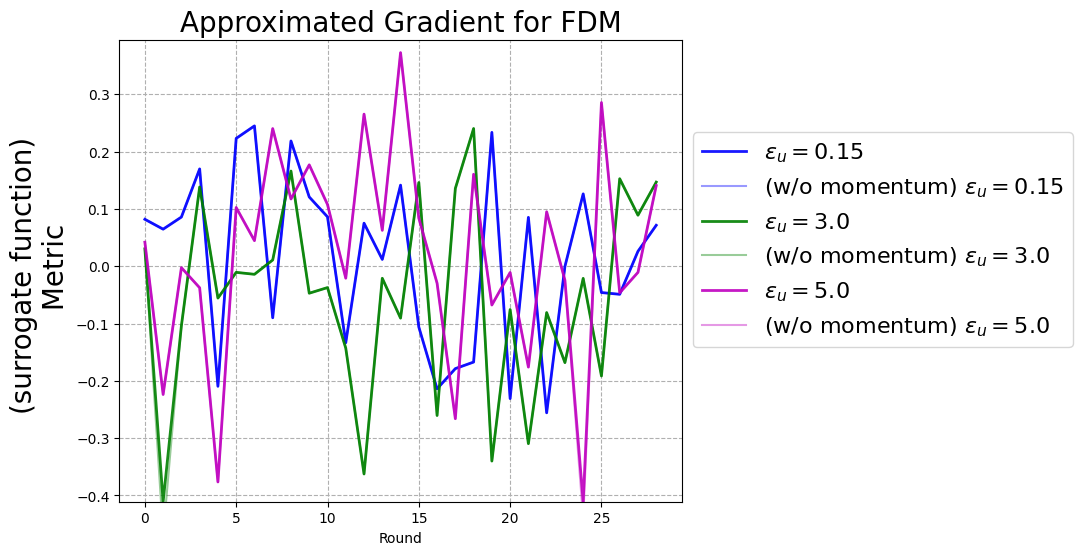

Result image saved to: /Users/fumiyuki/research/AcSilo/acsilo/exp/img/online_optimization_result-heart_disease-PULDP-AVG-QCTrain-0.5-random-updown.png


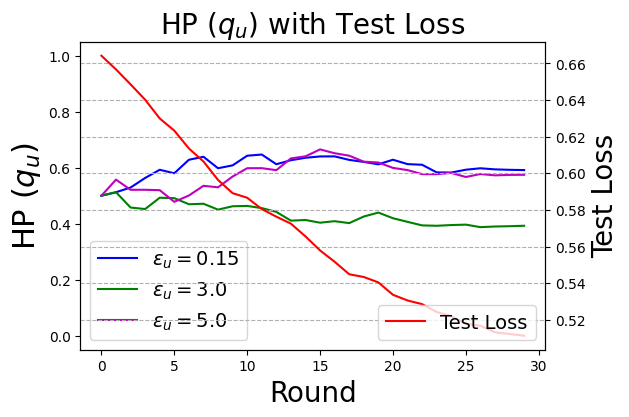

Result image saved to: /Users/fumiyuki/research/AcSilo/acsilo/exp/img/online_optimization_result-losses-heart_disease-PULDP-AVG-QCTrain-0.5-random-updown.png


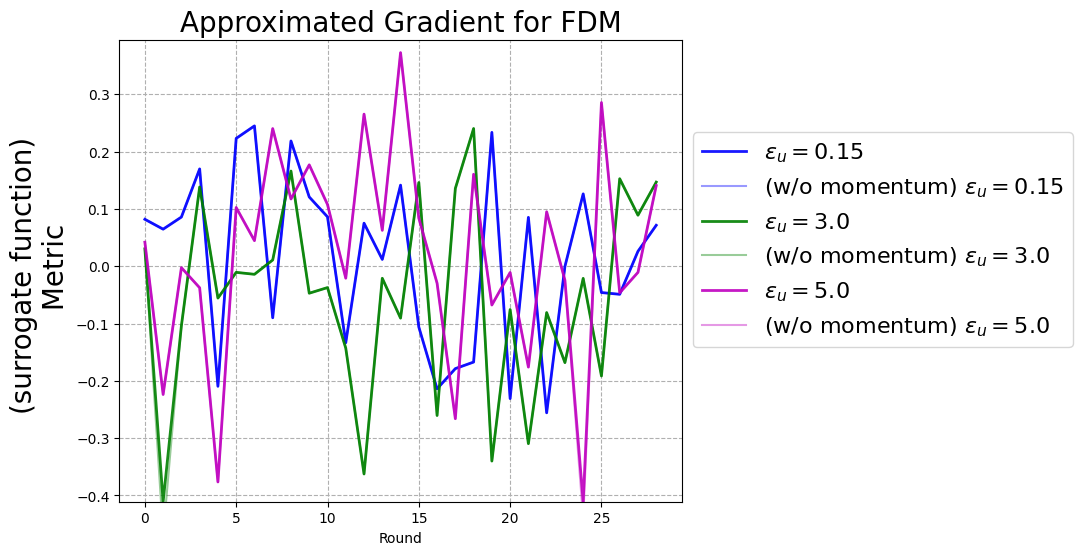

Result image saved to: /Users/fumiyuki/research/AcSilo/acsilo/exp/img/online_optimization_result-heart_disease-PULDP-AVG-QCTrain-1.0-random-updown.png


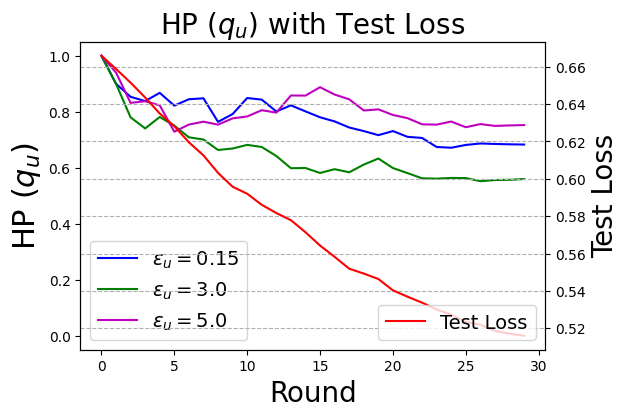

Result image saved to: /Users/fumiyuki/research/AcSilo/acsilo/exp/img/online_optimization_result-losses-heart_disease-PULDP-AVG-QCTrain-1.0-random-updown.png


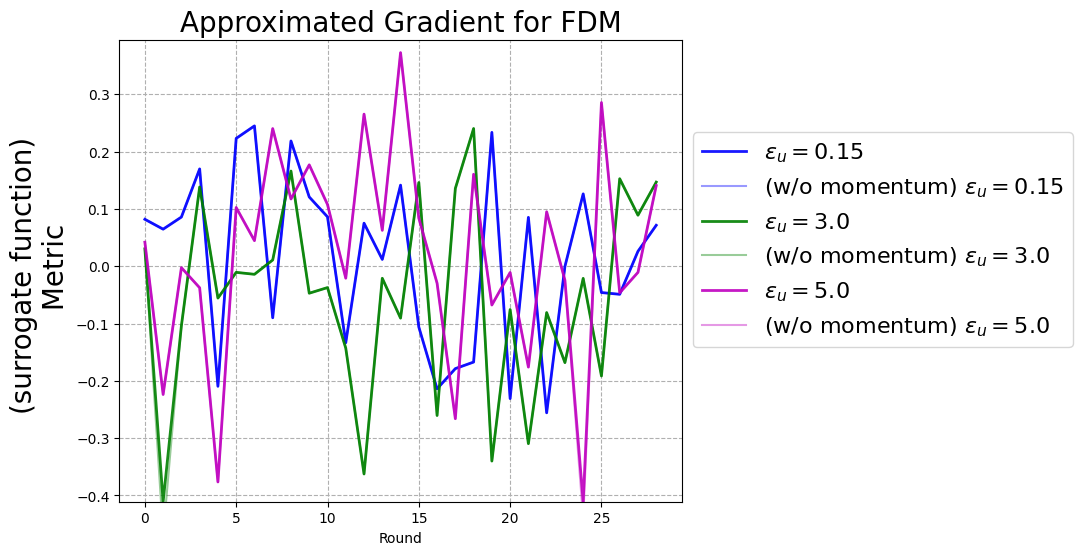

In [ ]:
n_users = 400
sigma = 1.0
epsilon_list = [0.15, 3.0, 5.0]
group_thresholds = epsilon_list
ratio_list = [0.6, 0.25, 0.15]
delta = 1e-5
n_round = 30
dataset_name = 'heart_disease'
q_step_size = 0.8
initial_q_u_list = [0.1, 0.5, 1.0]
validation_ratio = 0.5
times = 10
agg_strategy = "PULDP-AVG-QCTrain"
with_momentum = True
step_decay = True
hp_baseline = "random-updown"

logger_set_warning()

for initial_q_u in initial_q_u_list:
    random_state = np.random.RandomState(0)
    epsilon_u_dct = make_epsilon_u(n_users=n_users, dist="hetero", epsilon_list=epsilon_list, ratio_list=ratio_list, random_state=random_state)
    grouped = group_by_closest_below(epsilon_u_dct=epsilon_u_dct, group_thresholds=group_thresholds)
    epsilon_u = {}
    for eps_u, user_ids in grouped.items():
        for user_id in user_ids:
            epsilon_u[user_id] = eps_u
    if not is_from_pickle:
        run_online_optimization(
            epsilon_u, sigma, delta, n_users, n_round, dataset_name, q_step_size, 
            group_thresholds, times, global_learning_rate=10.0, local_learning_rate=0.001, 
            local_epochs=30, validation_ratio=validation_ratio, agg_strategy=agg_strategy, 
            with_momentum=with_momentum, step_decay=step_decay, hp_baseline=hp_baseline,
            user_dist="uniform-iid", silo_dist="uniform", initial_q_u=initial_q_u,
        )
    x, acc_means, acc_stds = show_online_optimization_result(
        epsilon_u, sigma, delta, n_users, n_round, dataset_name, q_step_size, 
        validation_ratio=validation_ratio, agg_strategy=agg_strategy, with_momentum=with_momentum, initial_q_u=initial_q_u,
        step_decay=step_decay, hp_baseline=hp_baseline, errorbar=False, img_name=f"{dataset_name}-{agg_strategy}-{initial_q_u}-{hp_baseline}",
        global_learning_rate=10.0, local_learning_rate=0.001, local_epochs=30
    )
    hd_all_acc_results[(hp_baseline, initial_q_u)] = (x, acc_means, acc_stds)

##### Random

Result image saved to: /Users/fumiyuki/research/AcSilo/acsilo/exp/img/online_optimization_result-heart_disease-PULDP-AVG-QCTrain-1.0-random.png


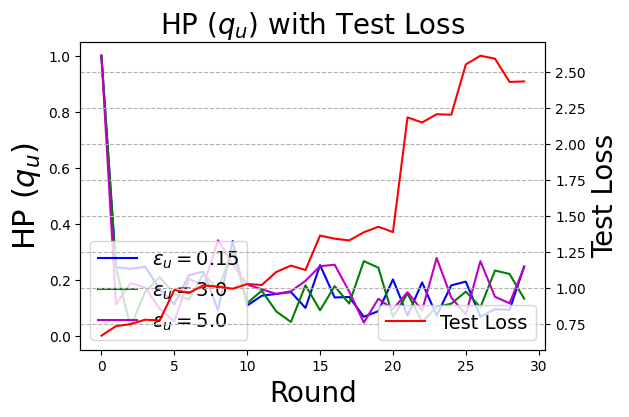

Result image saved to: /Users/fumiyuki/research/AcSilo/acsilo/exp/img/online_optimization_result-losses-heart_disease-PULDP-AVG-QCTrain-1.0-random.png


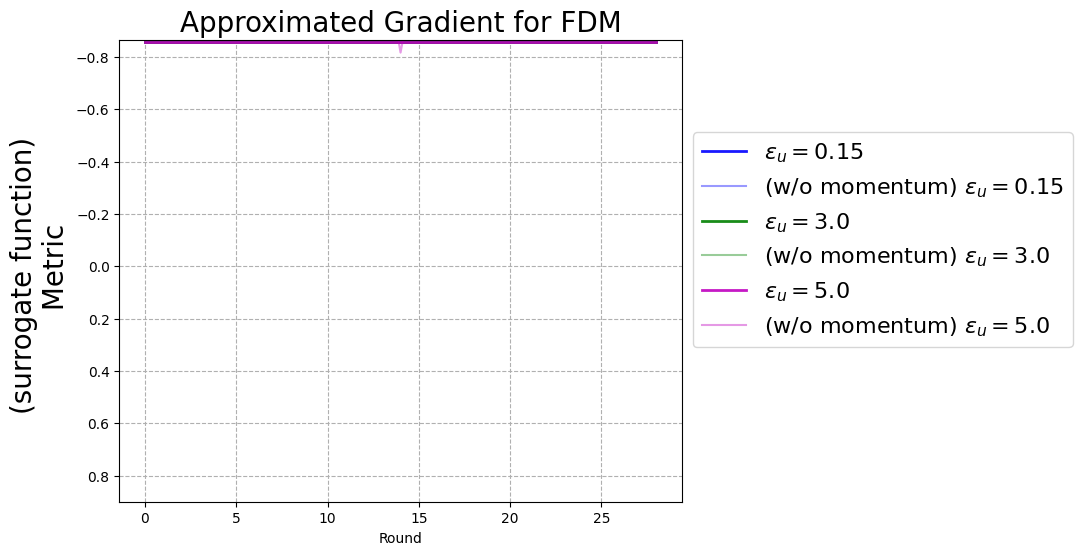

In [ ]:
n_users = 400
sigma = 1.0
epsilon_list = [0.15, 3.0, 5.0]
group_thresholds = epsilon_list
ratio_list = [0.6, 0.25, 0.15]
delta = 1e-5
n_round = 30
dataset_name = 'heart_disease'
q_step_size = 0.8
initial_q_u = 1.0
validation_ratio = 0.5
times = 10
random_state = np.random.RandomState(0)
agg_strategy = "PULDP-AVG-QCTrain"
with_momentum = True
step_decay = True
hp_baseline = "random"

logger_set_warning()

epsilon_u_dct = make_epsilon_u(n_users=n_users, dist="hetero", epsilon_list=epsilon_list, ratio_list=ratio_list, random_state=random_state)
grouped = group_by_closest_below(epsilon_u_dct=epsilon_u_dct, group_thresholds=group_thresholds)
epsilon_u = {}
for eps_u, user_ids in grouped.items():
    for user_id in user_ids:
        epsilon_u[user_id] = eps_u
if not is_from_pickle:
    run_online_optimization(
        epsilon_u, sigma, delta, n_users, n_round, dataset_name, q_step_size, 
        group_thresholds, times, global_learning_rate=10.0, local_learning_rate=0.001, 
        local_epochs=30, validation_ratio=validation_ratio, agg_strategy=agg_strategy, 
        with_momentum=with_momentum, step_decay=step_decay, hp_baseline=hp_baseline,
        user_dist="uniform-iid", silo_dist="uniform", initial_q_u=initial_q_u,
    )
x, acc_means, acc_stds = show_online_optimization_result(
    epsilon_u, sigma, delta, n_users, n_round, dataset_name, q_step_size, 
    validation_ratio=validation_ratio, agg_strategy=agg_strategy, with_momentum=with_momentum, initial_q_u=initial_q_u,
    step_decay=step_decay, hp_baseline=hp_baseline, errorbar=False, img_name=f"{dataset_name}-{agg_strategy}-{initial_q_u}-{hp_baseline}",
    global_learning_rate=10.0, local_learning_rate=0.001, local_epochs=30
)
hd_all_acc_results[(hp_baseline, "Random")] = (x, acc_means, acc_stds)

##### ULDP-AVG

In [4]:
n_users = 400
sigma = 1.0
epsilon_list = [0.15]
group_thresholds = epsilon_list
ratio_list = [1.0]
delta = 1e-5
n_round = 30
dataset_name = 'heart_disease'
q_step_size = 0.8
validation_ratio = 0.0
times = 10
random_state = np.random.RandomState(1)
agg_strategy = "PULDP-AVG"
with_momentum = True
step_decay = True
hp_baseline = None
static_q_u_list = [1.0, 0.9, 0.8, 0.7, 0.5, 0.3, 0.1]

logger_set_warning()

idx_per_group = {0.15: 6}
epsilon_u_dct = make_epsilon_u(n_users=n_users, dist="hetero", epsilon_list=epsilon_list, ratio_list=ratio_list, random_state=random_state)
grouped = group_by_closest_below(epsilon_u_dct=epsilon_u_dct, group_thresholds=group_thresholds)
epsilon_u = {}
for eps_u, user_ids in grouped.items():
    for user_id in user_ids:
        epsilon_u[user_id] = eps_u
prefix_epsilon_u = list(epsilon_u.items())[:4]

if not is_from_pickle:
    run_with_specified_idx(
        epsilon_u, sigma, delta, n_users, n_round, dataset_name, q_step_size, times, 
        static_q_u_list=static_q_u_list, user_dist="uniform-iid", silo_dist="uniform", validation_ratio=validation_ratio,
        idx_per_group=idx_per_group, global_learning_rate=10.0, local_learning_rate=0.001, local_epochs=30, force_update=True, parallelized=True, seed=1
    )
x, acc_means, acc_stds = show_specified_idx_result(
    prefix_epsilon_u, sigma, delta, n_users, n_round, dataset_name, q_step_size, 
    idx_per_group, validation_ratio=validation_ratio, img_name=f"{dataset_name}-ULDPAVG", errorbar=False, static_q_u_list=static_q_u_list, 
    global_learning_rate=10.0, local_learning_rate=0.001, local_epochs=30
)

hd_all_acc_results[(agg_strategy, "ULDP-AVG (Baseline)")] = (x, acc_means, acc_stds)

======== TIME: 0 start
======== TIME: 1 start
======== TIME: 2 start


======== TIME: 0 start
======== TIME: 1 start
======== TIME: 2 start
======== TIME: 3 start
======== TIME: 4 start
======== TIME: 5 start
======== TIME: 6 start
======== TIME: 7 start
======== TIME: 8 start
======== TIME: 9 start


02/05/2024 19:11:13:WARNING:No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


TEST ACC: 0.7350 ± 0.0424 , TEST LOSS: 0.5697 ± 0.0664
Result image saved to: /Users/fumiyuki/research/AcSilo/acsilo/exp/img/specified_idx_result-heart_disease-ULDPAVG.png


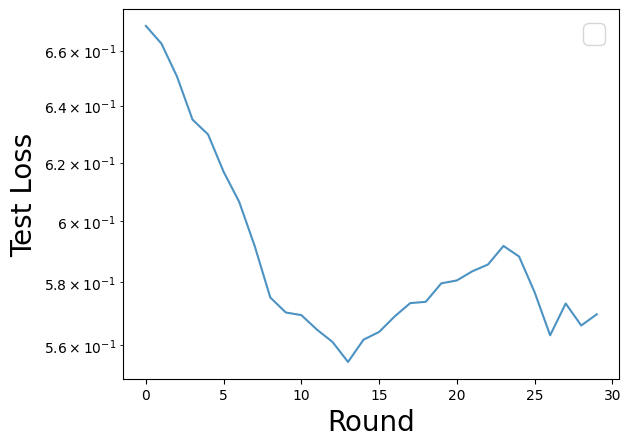

In [ ]:
n_users = 400
sigma = 1.0
epsilon_list = [0.15]
group_thresholds = epsilon_list
ratio_list = [1.0]
delta = 1e-5
n_round = 30
dataset_name = 'heart_disease'
q_step_size = 0.8
validation_ratio = 0.0
times = 10
random_state = np.random.RandomState(1)
agg_strategy = "PULDP-AVG"
with_momentum = True
step_decay = True
hp_baseline = None
static_q_u_list = [1.0, 0.9, 0.8, 0.7, 0.5, 0.3, 0.1]

logger_set_warning()

idx_per_group = {0.15: 6}
epsilon_u_dct = make_epsilon_u(n_users=n_users, dist="hetero", epsilon_list=epsilon_list, ratio_list=ratio_list, random_state=random_state)
grouped = group_by_closest_below(epsilon_u_dct=epsilon_u_dct, group_thresholds=group_thresholds)
epsilon_u = {}
for eps_u, user_ids in grouped.items():
    for user_id in user_ids:
        epsilon_u[user_id] = eps_u
prefix_epsilon_u = list(epsilon_u.items())[:4]

if not is_from_pickle:
    run_with_specified_idx(
        epsilon_u, sigma, delta, n_users, n_round, dataset_name, q_step_size, times, 
        static_q_u_list=static_q_u_list, user_dist="uniform-iid", silo_dist="uniform", validation_ratio=validation_ratio,
        idx_per_group=idx_per_group, global_learning_rate=10.0, local_learning_rate=0.001, local_epochs=30, force_update=True, parallelized=False, seed=1
    )
x, acc_means, acc_stds = show_specified_idx_result(
    prefix_epsilon_u, sigma, delta, n_users, n_round, dataset_name, q_step_size, 
    idx_per_group, validation_ratio=validation_ratio, img_name=f"{dataset_name}-ULDPAVG", errorbar=False, static_q_u_list=static_q_u_list, 
    global_learning_rate=10.0, local_learning_rate=0.001, local_epochs=30
)

hd_all_acc_results[(agg_strategy, "ULDP-AVG (Baseline)")] = (x, acc_means, acc_stds)

#### Compare all results

Result image saved to: /Users/fumiyuki/research/AcSilo/acsilo/exp/img/comparison-with-baselines-heart_disease-1.0.png


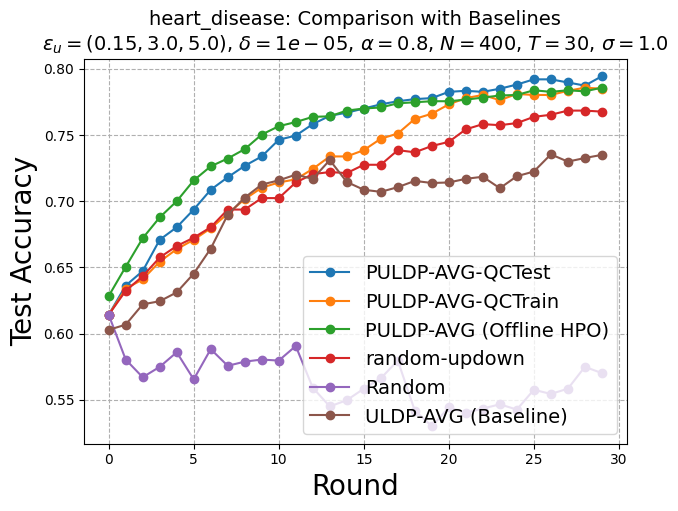

Result image saved to: /Users/fumiyuki/research/AcSilo/acsilo/exp/img/comparison-with-baselines-heart_disease-0.5.png


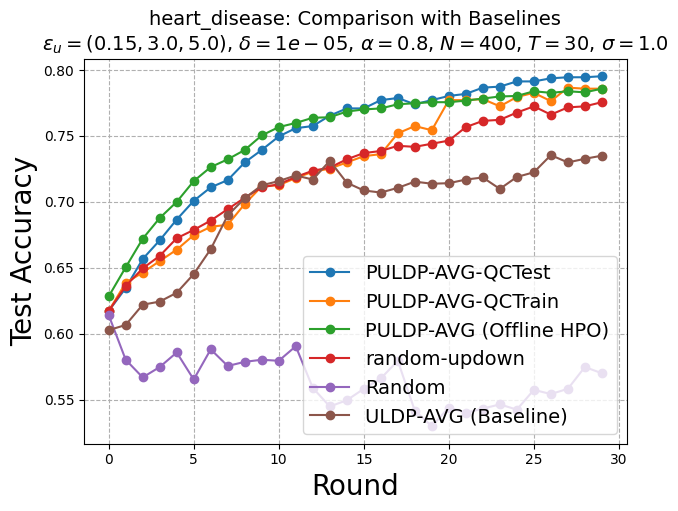

In [ ]:
plot_acc_results(hd_all_acc_results, dataset_name, initial_q_u_list=[1.0, 0.5], delta=1e-5,alpha=0.8, N=400, T=30, sigma=1.0, errorbar=False)